In [75]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle
from matplotlib import colors
import threading, queue
import scipy.io


from Tree import Node


In [76]:
#split s means we check all y-values to see if they're above or below the line
# %%
#split s means we check all y-values to see if they're above or below the line
'''
split cost functions
Desc: finds cost of a split
parameters: 
s: split value
c1: mean color left/below split [r,g,b]
c2: mean color right/above split [r,g,b]
'''
def hor_split_cost(s, y_values, vals):
    #get values left

    left_values = vals[np.where(y_values <= s)]
    right_values = vals[np.where(y_values > s)]

    c1 = np.mean(left_values, axis = 0)
    c2 = np.mean(right_values, axis = 0)

    left_values -= np.tile(c1, (np.shape(left_values)[0], 1))
    left_cost = np.sum(np.square(np.linalg.norm(left_values, axis=1)))
        
    right_values -= np.tile(c2, (np.shape(right_values)[0], 1))
    right_cost = np.sum(np.square(np.linalg.norm(right_values, axis=1)))
    cost = right_cost + left_cost
    return cost, c1, c2, right_cost, left_cost

def vert_split_cost(s, x_values, vals):
    #get values left 
    left_values = vals[np.where(x_values <= s)]
    right_values = vals[np.where(x_values > s)]
    c1 = np.mean(left_values, axis = 0)
    c2 = np.mean(right_values, axis = 0)
    #print(len(left_values))
    #print(c1)
    left_values -= np.tile(c1, (np.shape(left_values)[0], 1))
    left_cost = np.sum(np.square(np.linalg.norm(left_values, axis=1)))
        
    right_values -= np.tile(c2, (np.shape(right_values)[0], 1))
    right_cost = np.sum(np.square(np.linalg.norm(right_values, axis=1)))

    #print(left_values)
    cost = left_cost + right_cost
    return cost, c1, c2, right_cost, left_cost

In [77]:
'''
Returns direction & optimal split value
'''
def OptimalSplitRegression(x_data,y_data,vals):

    #pre-sort X & Y values:
    x_sorted = np.sort(x_data)
    y_sorted = np.sort(y_data)
    
    #get split values by summing array with shifted array by 1 to right and taking mean of every entry
    x_splits = 0.5 * (x_sorted[:-1]+np.roll(x_sorted,-1)[:-1])
    y_splits = 0.5 * (y_sorted[:-1]+np.roll(y_sorted,-1)[:-1])
     
    min_cost = float('inf')
    min_c1: np.array
    min_c2: np.array
    min_direction = False
    min_s = 0
    min_LC = 0
    min_RC = 0
    #print("starting splits")
    #find min cost split among both x and y splits
    for x_split in x_splits:
        cost, c1, c2, left_cost, right_cost = vert_split_cost(x_split, x_data, vals)
        #print(f'x_split: {x_split}; cost: {cost}')
        if(cost <= min_cost):
            min_s = x_split
            min_cost = cost
            min_c1 = c1
            min_c2 = c2
            min_direction = True
            min_LC = left_cost
            min_RC = right_cost
    
    #print("Done with X splits")
    for y_split in y_splits:
        cost, c1, c2, left_cost, right_cost = hor_split_cost(y_split, y_data, vals)
        #print(f'y_split: {y_split}; cost: {cost}')
        if(cost <= min_cost):
            min_s = y_split
            min_cost = cost
            min_c1 = c1
            min_c2 = c2
            min_direction = False
            min_LC = left_cost
            min_RC = right_cost

    return min_s, min_cost, min_c1, min_c2, min_direction, min_LC, min_RC

In [78]:
#get matlab data as nested dictionary
image = scipy.io.loadmat('MysteryImage.mat')

#extract compressed matrix from dictionaries

#columns: y-axis; rows: x-axis; vals: [r,g,b]
Y = image['cols'][...,0]
X = image['rows'][...,0]
V = image['vals']

# number of pixels
n = np.shape(X)[0]

In [79]:
#Code for Regression Tree:
MAX_ITTER = 50000
x_dim = 1456
y_dim = 2592

#stores leaves to consider
q = []
# X_points, Y_points, x_min, x_max, y_min, y_max, color
init_node = Node(X, Y, V, 0, x_dim, 0, y_dim)

q.append(init_node)
itter = 0
img = np.zeros((x_dim, y_dim, 3))

#q.qsize() function is inaccurate, so we use our own count
leaf_list = []
while itter < MAX_ITTER and len(q) > 0:
    itter += 1
    print(f"itteration: {itter}")
    curr_node = q.pop(0)
    s, cost, c1, c2, direction, min_LC, min_RC = OptimalSplitRegression(curr_node.x_elements,curr_node.y_elements,curr_node.vals)
    #print(curr_node.x_elements, curr_node.y_elements)
    #write to our image with the current split
    print(f"s: {s}, c1: {c1}, c2: {c2}")
    left_node = None
    right_node = None
    if(not direction):
        #horizontal cut:
        y_left = curr_node.y_elements[curr_node.y_elements <= s]
        y_right = curr_node.y_elements[curr_node.y_elements > s]

        lefts = np.where(curr_node.y_elements <= s)
        rights = np.where(curr_node.y_elements > s)

        left_values = curr_node.vals[lefts]
        right_values = curr_node.vals[rights]

        #create children node we push to the queue: 
        left_node = Node(curr_node.x_elements[lefts], y_left, left_values, curr_node.x_min, curr_node.x_max, curr_node.y_min, int(s))
        right_node = Node(curr_node.x_elements[rights], y_right, right_values, curr_node.x_min, curr_node.x_max, int(s), curr_node.y_max)
        #print("len lengths: ", lefts, rights, np.size(lefts))
    else:
        #vertical cut:
        x_left = curr_node.x_elements[curr_node.x_elements <= s]
        x_right = curr_node.x_elements[curr_node.x_elements > s]
        lefts = np.where(curr_node.x_elements <= s)
        rights = np.where(curr_node.x_elements > s)
        left_values = curr_node.vals[lefts]
        right_values = curr_node.vals[rights]
        
        #create children node we push to the queue:
        left_node = Node(x_left, curr_node.y_elements[lefts], left_values, curr_node.x_min, int(s), curr_node.y_min, curr_node.y_max)
        right_node = Node(x_right, curr_node.y_elements[rights], right_values, int(s), curr_node.x_max, curr_node.y_min, curr_node.y_max)
        #print("len lengths: ", lefts, rights, np.size(lefts))
    #Enqueue nodes or if pure add them to list of lead nodes
    left_node.print_me()
    right_node.print_me()
    if(np.size(lefts) > 1 and min_LC > 0):
        q.append(left_node)
    else:
        leaf_list.append(left_node)
    if(np.size(rights) > 1 and min_RC > 0):
        q.append(right_node)
    else:
        leaf_list.append(right_node)

itteration: 1
s: 1008.5, c1: [0.49501273 0.48181897 0.4739507 ], c2: [0.64320374 0.64354219 0.62310635]
x:(0, 1008); y:(0, 2592)
x:(1008, 1456); y:(0, 2592)
itteration: 2
s: 293.5, c1: [0.51978242 0.43367338 0.38416911], c2: [0.48500242 0.5012763  0.51023462]
x:(0, 293); y:(0, 2592)
x:(293, 1008); y:(0, 2592)
itteration: 3
s: 1139.0, c1: [0.68079492 0.67457071 0.64597627], c2: [0.61373319 0.61921661 0.6051769 ]
x:(1008, 1456); y:(0, 1139)
x:(1008, 1456); y:(1139, 2592)
itteration: 4
s: 1010.0, c1: [0.4936351  0.34579808 0.28980868], c2: [0.53603998 0.48831136 0.44283933]
x:(0, 293); y:(0, 1010)
x:(0, 293); y:(1010, 2592)
itteration: 5
s: 724.5, c1: [0.53176016 0.54587676 0.56187417], c2: [0.41414731 0.43369026 0.43198178]
x:(293, 724); y:(0, 2592)
x:(724, 1008); y:(0, 2592)
itteration: 6
s: 1309.5, c1: [0.69764082 0.68934873 0.66393435], c2: [0.64797405 0.64577867 0.6109885 ]
x:(1008, 1309); y:(0, 1139)
x:(1309, 1456); y:(0, 1139)
itteration: 7
s: 1051.5, c1: [0.56614741 0.55842827 0.5

Done splitting!


'\nwe need top get the indices of the values and then \n'

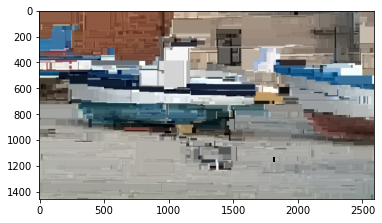

In [80]:
#print(itter, queue_count)
print("Done splitting!")
#draw on image with leaf nodes:
for node in leaf_list:
    img[node.x_min: node.x_max,  node.y_min:node.y_max] = np.mean(node.vals, axis = 0)
while len(q) >0:
    #print(q.qsize())
    node = q.pop(0)
    #print(node.x_min, node.x_max,  node.y_min,node.y_max, node.vals)
    img[node.x_min: node.x_max,  node.y_min:node.y_max] = np.mean(node.vals, axis = 0)

#we flip the axes so the x-axis and y-axis match up the way we want it to
plt.imshow(img.transpose(0,1,2), origin = "upper")

#plt.savefig("regression_tree2.png")
'''
we need top get the indices of the values and then 
'''
plt.savefig("regression_image.png")
'''
we need top get the indices of the values and then 
'''

In [81]:
print(q)

[]
